# Task 1: Genes
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
# Load libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import time

In [2]:
# Configure libraries
warnings.filterwarnings("ignore")

In [3]:
# Set location of data directory
data_path = os.path.join("..","Data-PR-As2","Genes")

In [4]:
# Load dataset (this takes a while)
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df_labels = pd.read_csv(os.path.join(data_path, "labels.csv"))

In [5]:
# Remove first columns as they just contain row names
df = df.iloc[:, 1:]
df_labels = df_labels.iloc[:, 1:]

## Data Analysis

In [6]:
# Dimensions of data
n_observations, n_features = df.shape
print("# observations:",n_observations," # features:", n_features)
classes = df_labels["Class"].unique()
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

# observations: 801  # features: 20531
There are 5 classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


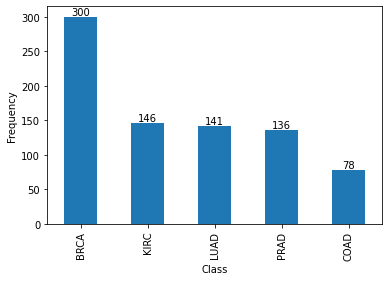

In [7]:
# Inspect frequency of class labels
ax = df_labels.apply(pd.value_counts).plot(kind='bar', legend=False)
ax.bar_label(ax.containers[0])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

There are 3 times more examples of BRCA than COAD. We therefore have a somewhat unbalanced dataset.

Min value: 0.0  Max value: 20.7788287118


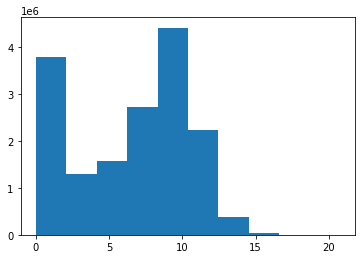

In [8]:
# Distribution of data across all features
df.stack().hist(grid=False)
df_np = df.to_numpy()
print("Min value:", df_np.min(), " Max value:", df_np.max())

In [9]:
# mean, std, min and max values vary between genes
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [10]:
def plot_tsne(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y.to_numpy().flatten(), 
                    palette=sns.color_palette(n_colors=n_classes), data=y)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

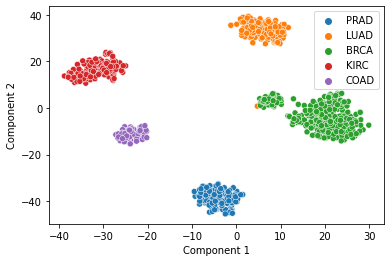

In [11]:
# Visualize multidimensional data
plot_tsne(df, df_labels)

## Feature Selection / Dimension Reduction

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=0)

In [13]:
# rm_cols = [col for col in X_train.columns if X_train[col].mean() == 0]
# X_train = X_train.drop(columns=rm_cols)

In [14]:
def best_pca(components, x_train, y_train, x_test, y_test, model, normalizer=None):
    scores = []
    for n in tqdm(components):
        pca = PCA(n_components=n)
        x_train_norm, x_test_norm = ((normalizer.fit_transform(x_train), normalizer.fit_transform(x_test))
                                     if normalizer else (x_train, x_test))
        X_train_pca = pca.fit_transform(x_train_norm)
        x_test_pca = pca.fit_transform(x_test_norm)
        y_pred = model.fit(X_train_pca, y_train).predict(x_test_pca)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

100%|███████████████████████████████████████████| 25/25 [00:47<00:00,  1.90s/it]


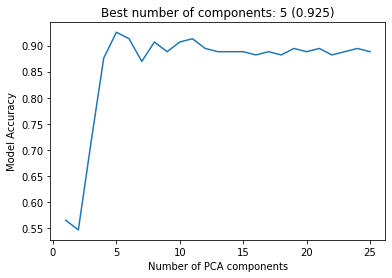

In [15]:
max_comp = 25
components = list(range(1, max_comp + 1))
normalizer = StandardScaler()
scores = best_pca(components, X_train, y_train, X_test, y_test, SVC(), normalizer)
plt.plot(components, scores)
plt.xlabel("Number of PCA components")
plt.ylabel("Model Accuracy")
plt.title("Best number of components: " + str(np.argmax(scores) + 1) + " (" + str(round(max(scores),3)) + ")")
plt.show()

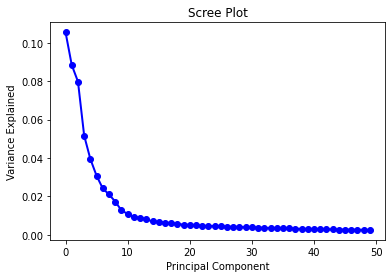

In [16]:
total_components = 50
pca = PCA(n_components=total_components)
pca.fit(normalizer.fit_transform(X_train))
plt.plot(list(range(total_components)), pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [22]:
# Which is faster (a bunch of features or PCA)
# Do this with cross-val but I think pca is faster lol

start_feat = time.time()
model = SVC()
out = model.fit(normalizer.fit_transform(X_train), y_train)
end_feat = time.time()
print("training diff:", end_feat - start_feat)
start_feat = time.time()
y_pred = out.predict(normalizer.fit_transform(X_test))
print(accuracy_score(y_test, y_pred))
end_feat = time.time()
print("predicting diff:", end_feat - start_feat)

start_pca = time.time()
model = SVC()
pca = PCA(n_components=5)
X_pca = pca.fit_transform(normalizer.fit_transform(X_train))
pca_out = model.fit(X_pca, y_train)
end_pca = time.time()
print("diff:", end_pca - start_pca)
y_pred = pca_out.predict(pca.fit_transform(normalizer.fit_transform(X_test)))
print(accuracy_score(y_test, y_pred))

diff: 2.2367591857910156
0.9937888198757764
diff: 0.8758718967437744
0.9254658385093167
